In [128]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [129]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform= ToTensor(),
)

In [130]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [131]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 28, 28])
9


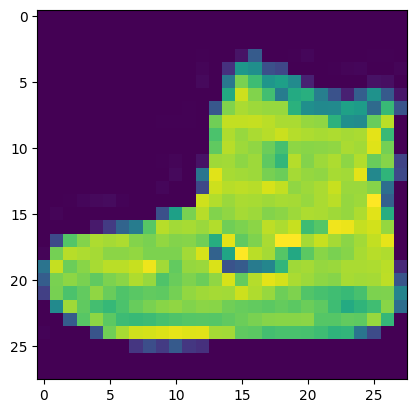

In [132]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze())
print(label)



torch.Size([1, 28, 28])
0


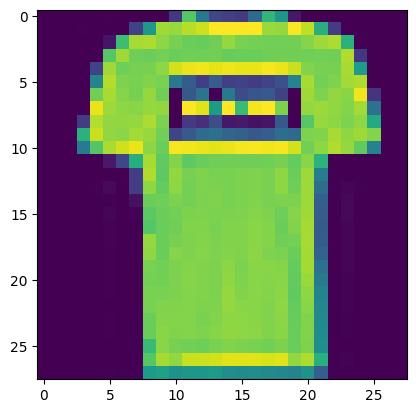

In [133]:

image, label = train_data[1]
print(image.shape)
plt.imshow(image.squeeze())
print(label)

Text(0.5, 1.0, 'T-shirt/top')

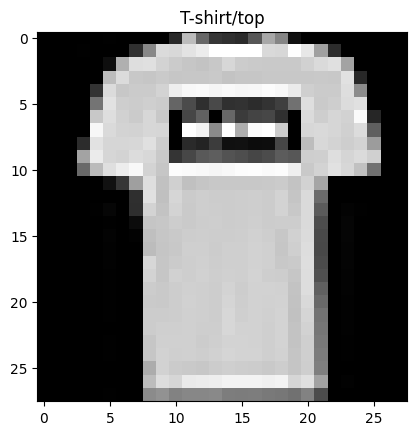

In [134]:
plt.imshow(image.squeeze(), cmap='grey')
plt.title(class_name[label])

2 DATALOADING

In [135]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)




In [136]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f'{len(train_dataloader)} of 32')
print(f'{len(test_dataloader)} of 32')



Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e34b20f72e0>, <torch.utils.data.dataloader.DataLoader object at 0x7e34b20f40a0>)
1875 of 32
313 of 32


Images shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])
Coat


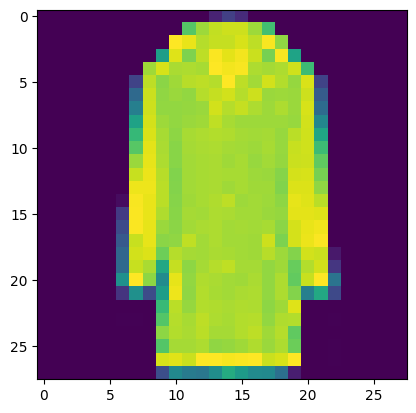

In [137]:
# Get the first batch
first_batch = next(iter(train_dataloader))

# Unpack the batch (assuming it contains images and labels)
images, labels = first_batch

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
plt.imshow(images[0].squeeze())
print(class_name[labels[0].item()])



3. MODEL0

In [138]:
from torch import nn

In [139]:
class fashionMINST(nn.Module):
  def __init__(self, input_shape, hidden_units, out_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(nn.Flatten(), nn.Linear(in_features=input_shape, out_features=hidden_units), nn.Linear(in_features=hidden_units, out_features=out_shape))

  def forward(self, x):
    return self.layer_stack(x)


In [140]:
device = 'cuda' if torch.cuda.is_available() else "cpu"


In [141]:
torch.manual_seed(42)

model0 = fashionMINST(input_shape=(28*28), hidden_units=10, out_shape=len(class_name))
model0.to('cpu')

fashionMINST(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [142]:
!pip install torchmetrics


In [143]:
from torchmetrics.classification  import Accuracy

acc = Accuracy(task='multiclass', num_classes=len(class_name))

In [144]:
acc = acc.to('cpu')

In [145]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1 )

In [146]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [147]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')

  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model0.train()

    y_train_pred = model0(X)
    loss_train = loss_fn(y_train_pred, y)

    optimizer.zero_grad()

    loss_train.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f'Looked at: {len(X)*batch}/{len(train_dataloader.dataset)}')

  loss_train = loss_train/len(train_dataloader)

  test_loss, test_acc = 0, 0

  model0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      test_pred = model0(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += acc(y, test_pred.argmax(dim=1))

    test_loss /= (len(test_dataloader))
    test_acc /= (len(test_dataloader))


  print(f'Epooch: {epoch} Trainging loss is: {loss_train}, Testing Loss is: {test_loss}, Accuracy on testing: {test_acc}')

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Epooch: 0 Trainging loss is: 0.0002480854163877666, Testing Loss is: 0.5095350742340088, Accuracy on testing: 0.8203873634338379
Epoch: 1
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Epooch: 1 Trainging loss is: 0.00032079117954708636, Testing Loss is: 0.47988998889923096, Accuracy on testing: 0.8319688439369202
Epoch: 2
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Epooch: 2 Trainging loss is: 0.00016972028242889792, Testing Loss is: 0.47663894295692444, Accuracy on testing: 0.8342651724815369
Train time on cpu: 55.390 seconds


In [148]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc):


  test_loss, test_acc = 0, 0
  model.eval()
  with torch.no_grad():

    for X, y in data_loader:

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc  += acc(y, test_pred.argmax(dim=1))

    test_loss  /= len(data_loader)
    test_acc /= len(data_loader)

  return {'model name': model.__class__.__name__,
          'model_loss': test_loss.item(),
          'model accuracy': test_acc.item()}

result = eval_model(model0, test_dataloader, loss_fn, acc)
result

{'model name': 'fashionMINST',
 'model_loss': 0.47663894295692444,
 'model accuracy': 0.8342651724815369}

In [149]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

MODEL 2

In [150]:
class FashionMNISTv2(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=out_features),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [151]:
torch.manual_seed(42)

model = FashionMNISTv2(in_features=784,hidden_features=10,out_features= len(class_name))

In [152]:
model.to(device)

FashionMNISTv2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [153]:
next(model.parameters()).device # check model device

device(type='cpu')

In [154]:
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [155]:
def train_step(model, loss_fn, optimizer, dataloader,accuracy_fn, device: torch.device = device):

  train_loss, train_acc = 0, 0

  model.to(device)
  for batch, (X, y) in enumerate(dataloader):

    model.train()
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f'Training Loss: {train_loss} Training Accuracy: {train_acc}')


def test_step(model, loss_fn, optimizer, dataloader, accuracy_fn, device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.to(device)
    model.eval()
    with torch.no_grad():
      for X, y in dataloader:
        X.to(device)
        y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)

        test_loss += loss
        test_acc += accuracy_fn(y, y_pred.argmax(dim=1))

      test_loss /= len(dataloader)
      test_acc /= len(dataloader)
      print(f'Testing Loss: {test_loss} Testing Accuracy: {test_acc}')

In [156]:
torch.manual_seed(42)
from tqdm.auto import tqdm


epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model, loss_fn1, optimizer1, train_dataloader, acc)

  test_step(model, loss_fn1, optimizer1, test_dataloader, acc)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Training Loss: 1.0919920206069946 Training Accuracy: 0.6134333610534668
Testing Loss: 0.9563649296760559 Testing Accuracy: 0.6499600410461426
Epoch: 1
Training Loss: 0.7810056805610657 Training Accuracy: 0.7192833423614502
Testing Loss: 0.7222670316696167 Testing Accuracy: 0.7391173839569092
Epoch: 2
Training Loss: 0.6702709794044495 Training Accuracy: 0.7593666911125183
Testing Loss: 0.6850009560585022 Testing Accuracy: 0.7501996755599976


In [157]:
result1 = eval_model(model, test_dataloader, loss_fn, acc)
result, result1


({'model name': 'fashionMINST',
  'model_loss': 0.47663894295692444,
  'model accuracy': 0.8342651724815369},
 {'model name': 'FashionMNISTv2',
  'model_loss': 0.6850009560585022,
  'model accuracy': 0.7501996755599976})

In [158]:
class fashionMINSTv3(nn.Module):
  def __init__(self, input_shape, hidden_layers, out_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_layers,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_layers, out_channels=hidden_layers,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_layers, out_channels=hidden_layers,kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_layers, out_channels=hidden_layers,kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=(hidden_layers*7*7), out_features=out_shape)
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x



In [159]:
torch.manual_seed(42)

model3 = fashionMINSTv3(input_shape=1, hidden_layers=15, out_shape=len(class_name)).to(device)
model3

fashionMINSTv3(
  (block_1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=735, out_features=10, bias=True)
  )
)

In [160]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")


Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]


In [161]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
l = conv_layer(test_image)
print(l.shape)

torch.Size([10, 62, 62])


In [162]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)
y = max_pool_layer(l)
print(y.shape)

torch.Size([10, 31, 31])


In [163]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model3.parameters(), lr=0.1)

In [164]:
from tqdm.auto import tqdm
epochs = 6

for epoch in tqdm(range(epochs)):
  train_step(model3, loss_fn, optimizer, train_dataloader, acc,)
  test_step(model3, loss_fn, optimizer, test_dataloader, acc,)

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.5861729979515076 Training Accuracy: 0.788433313369751
Testing Loss: 0.3767445683479309 Testing Accuracy: 0.8595247864723206
Training Loss: 0.34889867901802063 Training Accuracy: 0.8744333386421204
Testing Loss: 0.3452485203742981 Testing Accuracy: 0.8747004866600037
Training Loss: 0.30413171648979187 Training Accuracy: 0.8912666440010071
Testing Loss: 0.3106077015399933 Testing Accuracy: 0.8887779712677002
Training Loss: 0.28294476866722107 Training Accuracy: 0.8991333246231079
Testing Loss: 0.28416478633880615 Testing Accuracy: 0.8946685194969177
Training Loss: 0.2679721713066101 Training Accuracy: 0.9034500122070312
Testing Loss: 0.29308590292930603 Testing Accuracy: 0.8957667946815491
Training Loss: 0.2566097676753998 Training Accuracy: 0.9074833393096924
Testing Loss: 0.2835680842399597 Testing Accuracy: 0.9019568562507629


In [165]:
result2 = eval_model(model3, test_dataloader, loss_fn, acc)
result, result1, result2

({'model name': 'fashionMINST',
  'model_loss': 0.47663894295692444,
  'model accuracy': 0.8342651724815369},
 {'model name': 'FashionMNISTv2',
  'model_loss': 0.6850009560585022,
  'model accuracy': 0.7501996755599976},
 {'model name': 'fashionMINSTv3',
  'model_loss': 0.2835680842399597,
  'model accuracy': 0.9019568562507629})

Save the Model

In [167]:
from pathlib import Path

#create directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "cnn_model.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f'saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model3.state_dict(),f= MODEL_SAVE_PATH)


saving model to models/cnn_model.pt


In [170]:
model4 = fashionMINSTv3(input_shape=1, hidden_layers=15, out_shape=len(class_name))

In [171]:
model4.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-171-10d5470a0838>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model4.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [172]:
model4.to(device)

fashionMINSTv3(
  (block_1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=735, out_features=10, bias=True)
  )
)

In [175]:
result3 = eval_model(model4, test_dataloader, loss_fn, acc)
result2, result3


({'model name': 'fashionMINSTv3',
  'model_loss': 0.2835680842399597,
  'model accuracy': 0.9019568562507629},
 {'model name': 'fashionMINSTv3',
  'model_loss': 0.2835680842399597,
  'model accuracy': 0.9019568562507629})